A script to compare the performances of the two neural networks.

In [1]:
### Imports ###
from nntomo.utilities import get_MSE_loss
from nntomo.network import nnfbp_training, msdnet_training
from nntomo.nnfbp import DatasetNNFBP
from nntomo.msdnet import DatasetMSDNET
from nntomo.projection_stack import ProjectionStack
from nntomo.volume import Volume

%load_ext autoreload
%autoreload 2
%matplotlib widget

## Training set

In [4]:
ellipses_volume = Volume.stack_7ellipses(1000, shape=512)
ellipses_volume.save()

Generation of the ellipses: [████████████████████████████████████████████████████████████] 1000/1000 Est wait 00:0.0

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\rand7ellipses512.mrc.
 ID: rand7ellipses512


In [ ]:
ellipses_volume = Volume.retrieve('rand7ellipses512')

ellipses_9projections = ProjectionStack.from_volume(ellipses_volume, 9, 'full')
ellipses_8projections = ProjectionStack.from_volume(ellipses_volume, 8, 'tem')

training_dataset_nnfbp = DatasetNNFBP(ellipses_9projections, ellipses_volume)
training_dataset_nnfbp.save()

training_dataset_msdnet = DatasetMSDNET(ellipses_8projections, ellipses_volume)
training_dataset_msdnet.save()

## Validation set

In [6]:
spheres = Volume.random_spheres(30, shape=512)
spheres.save()

Generation of the spheres: [████████████████████████████████████████████████████████████] 30/30 Est wait 00:0.00

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\randspheres512.mrc.
 ID: randspheres512


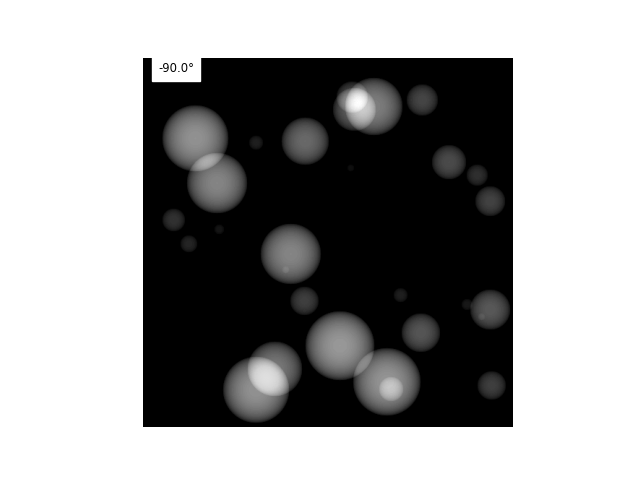

In [3]:
spheres = Volume.retrieve('randspheres512')

spheres_9projections = ProjectionStack.from_volume(spheres, 9, 'full')
spheres_8projections = ProjectionStack.from_volume(spheres, 8, 'tem')

#validation_dataset_nnfbp = DatasetNNFBP(spheres_9projections, spheres)
#validation_dataset_nnfbp.save()

#validation_dataset_msdnet = DatasetMSDNET(spheres_8projections, spheres)
#validation_dataset_msdnet.save()

## Neural network training

In [ ]:
# Dataset retrieving using the ids
training_dataset_nnfbp = DatasetNNFBP.retrieve("rand7ellipses512-full9th_rand7ellipses512_bin")
validation_dataset_nnfbp = DatasetNNFBP.retrieve("randspheres512-full9th_randspheres512_bin")

# Number of hidden nodes in the network
Nh = 8

# Training of NN-FBP
nnfbp = nnfbp_training(training_dataset_nnfbp, validation_dataset_nnfbp, Nh)

In [5]:
# Dataset retrieving using the ids
training_dataset_msdnet = DatasetNNFBP.retrieve("msdn_rand7ellipses512-tem8th_rand7ellipses512")
validation_dataset_msdnet = DatasetNNFBP.retrieve("msdn_randspheres512-tem8th_randspheres512")

# Training of NN-FBP
msdnet = msdnet_training(training_dataset_msdnet, validation_dataset_msdnet, depth=100, batch_size=2, max_epoch=50, learning_rate = 1e-3)

Start of training.


KeyboardInterrupt: 

## Reconstuctions

Computation of the reconstruction of the particule with 8 projections, using the network, and the SIRT algorithm. A quantitative comparison between NN-FBP and SIRT can then be made by computing the MSE loss of the reconstruction using a SIRT reconstruction with the 29 projections as a reference.

In [4]:
# The 29 projections stack of the MOF particule
mof_projections_file = "data/projection_files/HSH75-Pd-HAADF_hdr0.ali"
mof_29proj = ProjectionStack.from_mrc_file(mof_projections_file, 'tem').get_resized_proj((512,512))

# The stack with a subset of 8 projections
mof_8proj = mof_29proj.get_proj_subset(8)

c:\Users\Admin-tomo\anaconda3\envs\abtem_env\Lib\site-packages\mrcfile\mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
c:\Users\Admin-tomo\anaconda3\envs\abtem_env\Lib\site-packages\mrcfile\mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [5]:
# NN-FBP reconstruction for the 8 projections stack
nnfbp_reconstr_8proj = mof_8proj.get_NNFBP_reconstruction(nnfbp)
nnfbp_reconstr_8proj.save()

Start of NN reconstruction.
Reconstruction part 1/2: [████████████████████████████████████████████████████████████] 8/8 Est wait 00:0.010

Reconstruction part 2/2: [████████████████████████████████████████████████████████████] 8/8 Est wait 00:0.060

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\nnfbp_rand7ellipses512-full9th_rand7ellipses512_bin_8h_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8.mrc.
 ID: nnfbp_rand7ellipses512-full9th_rand7ellipses512_bin_8h_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8


In [8]:
# MSDNET reconstruction for the 8 projections stack
msdnet_reconstr_8proj = mof_8proj.get_MSDNET_reconstruction(msdnet)
msdnet_reconstr_8proj.save()

Start of FBP reconstruction.
FBP reconstruction: [████████████████████████████████████████████████████████████] 512/512 Est wait 00:0.0

MSDNET forward: [████████████████████████████████████████████████████████████] 512/512 Est wait 00:0.00

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\msdnet_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8.mrc.
 ID: msdnet_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8


In [9]:
# SIRT reconstructions for the 8 projections stack, with 150 iterations
sirt_reconstr_8proj = mof_8proj.get_SIRT_reconstruction(150)
sirt_reconstr_8proj.save()

Start of SIRT reconstruction.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt150_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8.mrc.
 ID: sirt150_HSH75-Pd-HAADF_hdr0-resized[512-512]-sub8


In [10]:
# SIRT reference reconstruction with 150 iterations
sirt_reconstr_29proj = mof_29proj.get_SIRT_reconstruction(150)
sirt_reconstr_29proj.save()

Start of SIRT reconstruction.
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt150_HSH75-Pd-HAADF_hdr0-resized[512-512].mrc.
 ID: sirt150_HSH75-Pd-HAADF_hdr0-resized[512-512]


## Segmentation and MSE computation

In [9]:
# Segmentation: all voxel values are set to 0 or 1, depending on a segmentation value. This value is set arbitrarily, by looking at the shape of the
# volume in imod (isosurface value).
nnfbp_reconstr_8proj = nnfbp_reconstr_8proj.get_segmented_volume(245/255)
sirt_reconstr_8proj = sirt_reconstr_8proj.get_segmented_volume(170/255)
sirt_reconstr_29proj = sirt_reconstr_29proj.get_segmented_volume(190/255)

In [10]:
# MSE computation
print(f"NN-FBP MSE: {get_MSE_loss(sirt_reconstr_29proj, nnfbp_reconstr_8proj)}")
print(f"SIRT MSE: {get_MSE_loss(sirt_reconstr_29proj, sirt_reconstr_8proj)}")

NN-FBP MSE: 0.0001929197460412979
SIRT MSE: 0.0002627996727824211


In [11]:
import torch
import cupy

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_reserved()/1024**2)
print(cupy.get_default_memory_pool().used_bytes()/1024**2)
print(cupy.get_default_memory_pool().total_bytes()/1024**2)

8.125
4096.0
24.078125
36.0
